<h3>Motivation behind bagging</h3>

We note that $\, \text{Var}(aX) = a^2 \text{Var}(X). \,$

Proof. Let $\, X \,$ be a random variable, and let $\, a \in \mathbb{R}. \,$ Now:

\begin{align*}
    \large \text{Var}(aX) &= \large \mathbb{E}[(aX - \mathbb{E}[aX])^2] \\
    &= \large \mathbb{E}[(aX - a \mathbb{E}[X])^2] \\
    &= \large \mathbb{E}[(a (X - \mathbb{E}[X]))^2] \\
    &= \large \mathbb{E}[a^2 (X - \mathbb{E}[X])^2] \\
    &= \large a^2 \mathbb{E}[(X - \mathbb{E}[X])^2] \\
    &= \large a^2 \text{Var}(X)
\end{align*}

We also note that the variance of a sum of *independent* random variables is the sum of their variances.

Let $\, X_1, ... , X_n \,$ be $\, n \,$ independent observations, each with variance $\, \sigma^2. \,$ Now, given the results above, the variance of the mean $\, \bar{X} \,$ is 

\begin{equation*}
    \text{Var}(\bar{X}) = \text{Var} \left(\frac{1}{n} \sum_{i=1}^{n} X_i \right) = \frac{1}{n^2} \text{Var} \left(\sum_{i=1}^{n} X_i \right) = \frac{1}{n^2} \sum_{i=1}^{n} \text{Var}(X_i) = \frac{1}{n^2} n \sigma^2 = \frac{\sigma^2}{n}.
\end{equation*}

In other words, **averaging a set of independent observations reduces variance** (by a factor of $\, 1/n \,$, where $\, n \,$ is the number of observations). 

This shows that the variance of the mean decreases as $\, n \,$ increases. Averaging reduces variablity because independent noise in individual observations tend to cancel out when taking the mean. The more observations one averages, the smaller the variability in the mean tends to be.

Hence, a natural way to reduce the variance (overfitting) and increase the test set accuracy of a machine learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. In other words, we could calculate $\, \hat{f}^{1}(x), \hat{f}^{2}(x), ... , \hat{f}^{B}(x) \,$ using *B* separate training sets, and average the results in order to obtain a single low-variance model:

$$ \hat{f}_{avg}(x) = \frac{1}{B} \sum_{i=1}^{B} \hat{f}^{b}(x). $$

This is of course not practical because we generally do not have acces to multiple training sets. Instead, we can *bootstrap* by taking repeated samples (with replacement) from the single training dataset. In this approach, we generate *B* different bootstrapped training datasets. We then train our algorithm separately on the *B* bootstrapped training datasets (obtaining *B* different models), and average the predictions:

$$ \hat{f}_{bag}(x) = \frac{1}{B} \sum_{i=b}^{B} \hat{f}^{*b}(x), $$

where $\, \hat{f}^{*b}(x) \,$ is the prediction obtained by training the model on the *b*th bootstrapped training dataset. This is called **bagging**.

- Bagging (*bootstrap aggregation*) is a general-purpose procedure for reducing the variance of a statistical learning method.
- The aggregation function is typically *mode* for classification (i.e., the most frequent prediction), and *average* for regression.
- Bagging is particularly useful and frequently used in the context of *decision trees*.

<h3>Bagging in sklearn</h3>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [18]:
X, y, = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

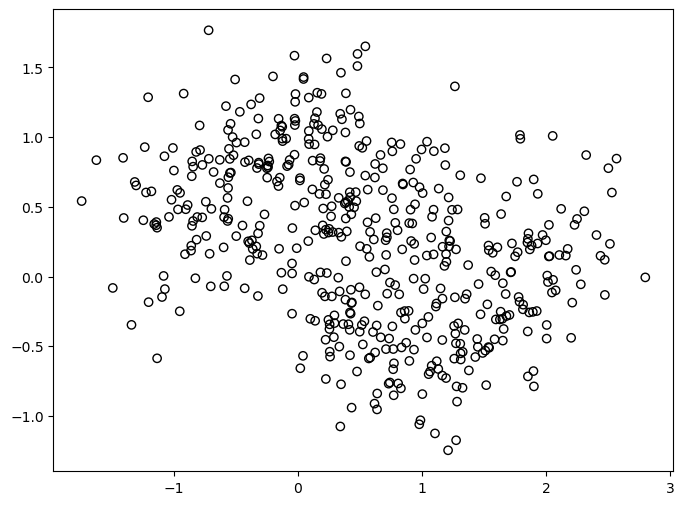

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='black');

In [21]:
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

- The `BaggingClassifier` above trains 500 decision tree classifier, where each decision tree is trained on 100 training instances that were sampled with replacement from the training dataset (i.e., bootstrapped)
- Note that a `BaggingClassifier` automatically performs *soft voting* instead of *hard voting* if the base clasifier can estimate class probabilities (i.e., if it has a `predict_proba()` method).

<h3>Comparing the decision boundaries of a single decision tree versus a bagging ensemble</h3>

In [22]:
single_tree_clf = DecisionTreeClassifier()
single_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
def plot_decision_boundaries(X, y, clf, ax, title):
    # Create a meshgrid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Make predictions on every grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Blues)
    
    # Define markers and colors or each class
    markers = ['o', '^']
    colors = ['black', 'orange']
    
    # Plot the original data (each class with a different marker and color)
    for i, label in enumerate(np.unique(y)):
        X_sub = X[y == label]
        ax.scatter(X_sub[:,0], X_sub[:,1], marker=markers[i], color=colors[i])
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)
    plt.tight_layout();

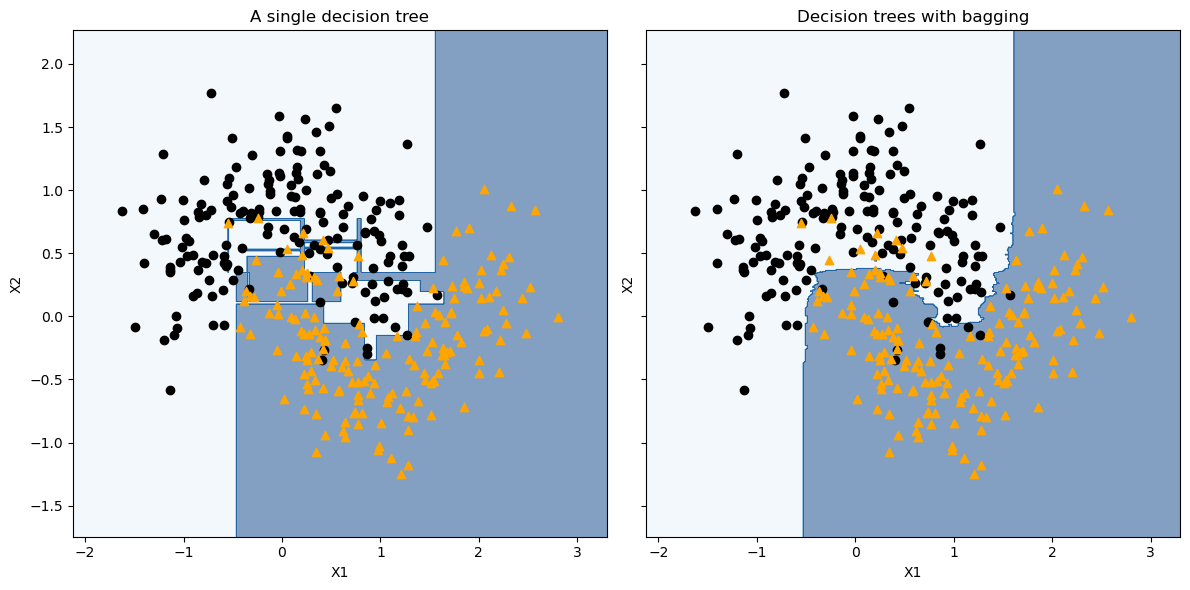

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
plot_decision_boundaries(X_train, y_train, single_tree_clf, ax=ax[0], title='A single decision tree')
plot_decision_boundaries(X_train, y_train, bag_clf, ax=ax[1], title='Decision trees with bagging')

- The ensemble's decision boundary is by far less complex (has more bias, but less variance), and will more likely generalize much better.

<h3>Out-of-bag evaluation (OOB)</h3>

In [67]:
# Just set oob_score=True (it is False by default)
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [69]:
bag_clf.oob_score_

0.9253731343283582

- According to this OOB evaluation, this `BaggingClassifier` is likely to achieve about 92.5% accuracy on the test set. Let's verify this:

In [74]:
y_pred_test = bag_clf.predict(X_test)
np.mean(y_test == y_pred_test).item()

0.9212121212121213

- Close enough.
- Let's see how the single decision tree performs with the test set:

In [75]:
np.mean(y_test == single_tree_clf.predict(X_test)).item()

0.8848484848484849

- It performs by far worse on new, unseen data.